In [3]:
NB_PATH = 'navbench'

import os
import sys
sys.path.append(NB_PATH)

import navbench as nb
from navbench import improc as ip
import matplotlib.pyplot as plt
from stitch import *

def show_image(ax, im):
    ax.imshow(im, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

## Rotational image difference function (RIDF) for single image

We compare a single image with itself over rotation. Notice that the image difference is at a minimum of zero at 0° (at which point the image is being compared to itself) and that the difference increases with rotation. This is the basis of the visual compass algorithm: that by comparing the current view with a stored view over rotation such that the difference is at a minimum will indicate the best-matching direction.

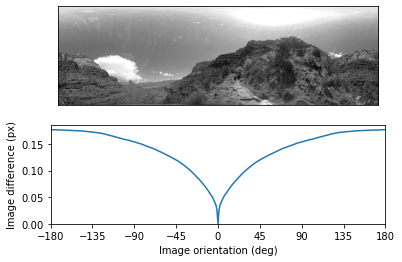

In [4]:
image = nb.read_images(os.path.join(NB_PATH, 'datasets/panorama_grand_canyon.jpg'), ip.to_float)
diffs = nb.ridf(image, image)

_, ax = plt.subplots(2)
show_image(ax[0], image)
nb.plot_ridf(diffs, ax[1])
ax[1].set_ylabel('Image difference (px)')
ax[1].set_xlabel('Image orientation (deg)');

## Image stitching
One approach to using the image data for navigation is to stitch the images recorded over each azimuthal sweep into single panoramas. There are some reconstructed panoramas shown below (left: manually stitched; right: using a fixed offset). As stitching seems to work rather well, this is one potential option.

20 images loaded
Diffs loaded from datasets/room/diffs.py
20 images loaded
Diffs loaded from datasets/kitchentop/diffs.py
40 images loaded
Diffs loaded from datasets/full_bath_20cm/diffs.py
20 images loaded
Image offset: 60.0
20 images loaded
Image offset: 60.0
40 images loaded
Image offset: 30.0


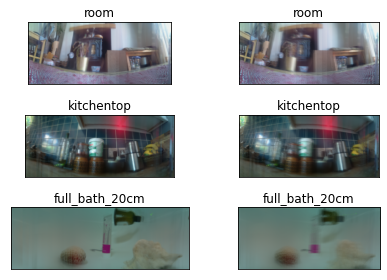

In [5]:
def show_stitched(ax, imset, fun):
    im = fun('datasets/' + imset)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(imset)

fig, ax = plt.subplots(3, 2)
show_stitched(ax[0, 0], 'room', stitch_interactive)
show_stitched(ax[1, 0], 'kitchentop', stitch_interactive)
show_stitched(ax[2, 0], 'full_bath_20cm', stitch_interactive)

show_stitched(ax[0, 1], 'room', lambda x: stitch_static(x, from_left=False))
show_stitched(ax[1, 1], 'kitchentop', lambda x: stitch_static(x, from_left=False))
show_stitched(ax[2, 1], 'full_bath_20cm', lambda x: stitch_static(x, from_left=True))
fig.tight_layout()

## RIDFs for image segments
This shows how performance would be *without* image stitching. The blue line indicates performance for a "real" panorama (i.e. a control) and the other lines show the RIDFs for other datasets.

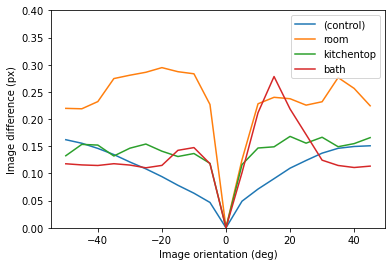

In [6]:
deg_sep = 5 # deg
rot_rng = range(-50, 50, deg_sep)
fov_deg = 52 # deg
snap_idx = len(rot_rng) // 2

gc_images = []
for rot in rot_rng:
    lo = int(180 + rot - fov_deg / 2)
    hi = lo + fov_deg
    im = image[:, lo:hi]
    gc_images.append(im)
gc_diffs = nb.route_idf(gc_images, gc_images[snap_idx])

plt.plot(rot_rng, gc_diffs)
plt.xlabel('Image orientation (deg)')
plt.ylabel('Image difference (px)')
plt.ylim(bottom=0)

# Load image set at same resolution as for panorama segments
resize = ip.resize(*gc_images[0].shape[1::-1])

datasets = ('room', 'kitchentop', 'bath')
for dataset in datasets:
    db = nb.Database('datasets/' + dataset)
    assert len(db) == len(rot_rng)
    images = db.read_images(preprocess=resize)
    diffs = nb.route_idf(images, images[snap_idx])
    plt.plot(rot_rng, diffs)

plt.ylim(0, 0.4)
plt.legend(['(control)', *datasets]);

In [7]:
import numpy as np

def plot_dbs(clear_path, cloudy_path):
    rot_rng = np.linspace(-50, 50, 40)
    db_clear = nb.Database('datasets/' + clear_path)
    db_cloudy = nb.Database('datasets/' + cloudy_path)
    assert len(rot_rng) == len(db_clear)
    assert len(rot_rng) == len(db_cloudy)

    preprocess_conds = (None, ip.histeq)
    titles = ('No preprocessing', 'Histogram equalisation')

    fig, axes = plt.subplots(len(preprocess_conds))
    for ax, title, preprocess in zip(axes, titles, preprocess_conds):
        images_clear = db_clear.read_images(preprocess=preprocess)
        images_cloudy = db_cloudy.read_images(preprocess=preprocess)

        datasets = ((images_clear, images_clear), (images_cloudy, images_cloudy),
                    (images_clear, images_cloudy), (images_cloudy, images_clear))
        snap_idx = len(rot_rng) // 2
        num_zeros = 0
        for train, test in datasets:
            diffs = nb.route_idf(train, test[snap_idx])
            zeros_sel = diffs == 0
            diffs[zeros_sel] = None # filter out zeros
            num_zeros += sum(zeros_sel)
            ax.plot(rot_rng, diffs)
        ax.set_xlabel('Image orientation (deg)')
        ax.set_ylabel('Image difference (px)')
        ax.set_ylim(bottom=0)
        ax.set_title(title)

        print(f"Warning: Filtering out {num_zeros} zero values")

    labels = ('Clear/clear', 'Cloudy/cloudy', 'Clear/cloudy', 'Cloudy/clear')
    plt.legend(labels)
    fig.tight_layout()

## Full vs cloudy bath
Performance is comparable when training and testing using same dataset. However, changing from clear to cloudy water (or vice versa) seriously affects navigation.

Using histogram equalisation ameliorates this somewhat (note the difference in *y*-axis scale between plots), but the minima are still fairly shallow.

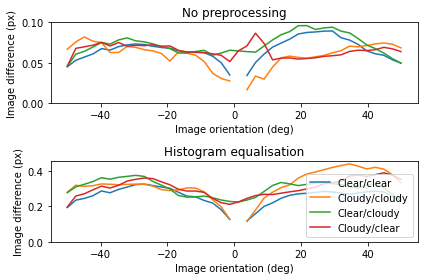

In [8]:
plot_dbs('full_bath_20cm', 'full_bath_20cm_cloudy')

## Comparison with 60cm of bath water
Below are the same plots for the other bathtub datasets.

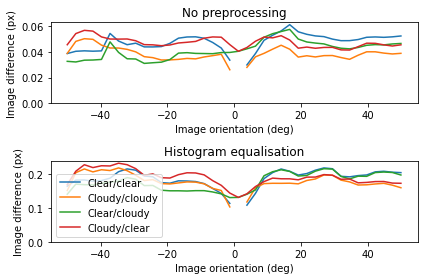

In [9]:
plot_dbs('full_bath_60cm', 'full_bath_60cm_running')